# Predicting cryptocurrency prices using DL
Cryptocurrency, an encrypted, p2p network for promoting digital trade, is a technology invented in 2008. Bitcoin is the first and most popular cryptocurrency invented in 2008 by an unknown person (Satoshi Nakamoto). 

The goal of this article is to predict bitcoin prices using a famous DL model "Long Short Term Memory". In this article, we only consider Bitcoin, but it wouldn't be hard to add the other coins.

## Step 1 - Setup Environment and Dataset
First of all, We need to setup the project environment. 
We can setup a virtual environment using Anaconda. (https://www.anaconda.com/)

Then, we need to setup the price dataset for predicting.
We can obtain Bitcoin prices from exchanges.

### Step 1.1 - Import the Dependencies At The Top of The Notebook¶
Once you've got a blank Jupyter notebook open, the first thing we'll do is import the required dependencies.<br>
You may need do "pip install" or "conda install" pandas, numpy, matplotlib in your project environment, <br>
if you don't have these libraries in your project environment.


In [1]:
import io
import sys
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from PIL import Image

### Step 1.2 - Scrape Price Data from Exchanges.
We can obtain price data from this site:  http://history.btc126.com/data/btc/2013/

In [2]:
# Scrape price data table from an exchange.
price_df = pd.DataFrame()
for year in range(2013, 2021):
    url = "http://history.btc126.com/data/btc/{}/".format(year)
    price_df = price_df.append(
        pd.read_html(url), ignore_index=True
    )

After obtain a table, we need check the table values.

In [3]:
# Check the first few rows
price_df.head()

,时间,开盘价($),最高价($),最低价($),收盘价($),交易量($),市值($)
0,2013-12-31,760.32,760.58,738.17,754.01,20897300,9191325349
1,2013-12-30,741.35,766.60,740.24,756.13,20707700,9217167990
2,2013-12-29,728.05,748.61,714.44,745.05,19011300,9082103621
3,2013-12-28,737.98,747.06,705.35,727.83,32505800,8869918644
4,2013-12-27,763.28,777.51,713.60,735.07,46862700,8955394564


In [4]:
# Check some information including size, null values, data types, etc.
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869 entries, 0 to 2868
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间      2869 non-null   object 
 1   开盘价($)  2869 non-null   float64
 2   最高价($)  2869 non-null   float64
 3   最低价($)  2869 non-null   float64
 4   收盘价($)  2869 non-null   float64
 5   交易量($)  2869 non-null   int64  
 6   市值($)   2869 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 157.0+ KB


In [5]:
# more information for values
price_df.describe()

,开盘价($),最高价($),最低价($),收盘价($),交易量($),市值($)
count,2869.000000,2869.000000,2869.000000,2869.000000,2.869000e+03,2.869000e+03
mean,3654.344709,3746.325647,3557.740129,3659.841325,6.582433e+09,6.370807e+10
std,4140.344385,4254.424660,4014.214437,4145.892235,1.115644e+10,7.408703e+10
min,13.300000,13.400000,13.200000,13.300000,1.707160e+05,0.000000e+00
25%,374.730000,382.530000,366.670000,375.070000,3.931140e+07,5.125958e+09
50%,867.210000,897.020000,829.450000,868.480000,1.315700e+08,1.246294e+10
75%,7189.580000,7342.250000,7007.310000,7193.600000,7.713020e+09,1.264292e+11
max,19475.800000,20089.000000,18974.100000,19497.400000,7.415677e+10,3.265025e+11


## Step 2 - Data Preprocessing
1. Since we scraped the price dataset from a chinese website, <br>
We need change chinese index name to English. <br>


2. The datatype of "Date" data in the dataset is a "object" instead of a "datetime64",<br>
We need change the datatype of "Date" data. <br>


3. We only use previous close prices to predict next close price in this article, <br>
Therefore, we will delete some features from the dataset. <br>


4. After the data preprocessing, we will split the dataset to training set and test set.  

### Step 2.1 - Change index name

In [6]:
# Change the indexes to English, Since the indexes are Chinese now.
price_df.columns = ["Date", "Open", "High", "Low", 
                               "Close", "Volume", "Market Cap"]

### Step 2.2 - Change the datatype of "Date" data

In [7]:
# convert the date string to the correct date format
price_df = price_df.assign(
    Date=pd.to_datetime(price_df['Date'])
)

# Reverse the table by date descending
price_df = price_df.sort_values(
    by="Date", ascending=False
)

# Check the data info
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 2556 to 364
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2869 non-null   datetime64[ns]
 1   Open        2869 non-null   float64       
 2   High        2869 non-null   float64       
 3   Low         2869 non-null   float64       
 4   Close       2869 non-null   float64       
 5   Volume      2869 non-null   int64         
 6   Market Cap  2869 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 179.3 KB


### Step 2.3 - Delete Some Features from the Dataset

In [8]:
# Remove some features 
model_data = price_df[['Date','Close']]

# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')

# Check the model data
model_data.head()

,Date,Close
364,2013-01-01,13.3
363,2013-01-02,13.3
362,2013-01-03,13.4
361,2013-01-04,13.5
360,2013-01-05,13.4


### Step 2.4 - Split dataset to Training set and Test set

In [9]:
# Get the Bitcoin logos
if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

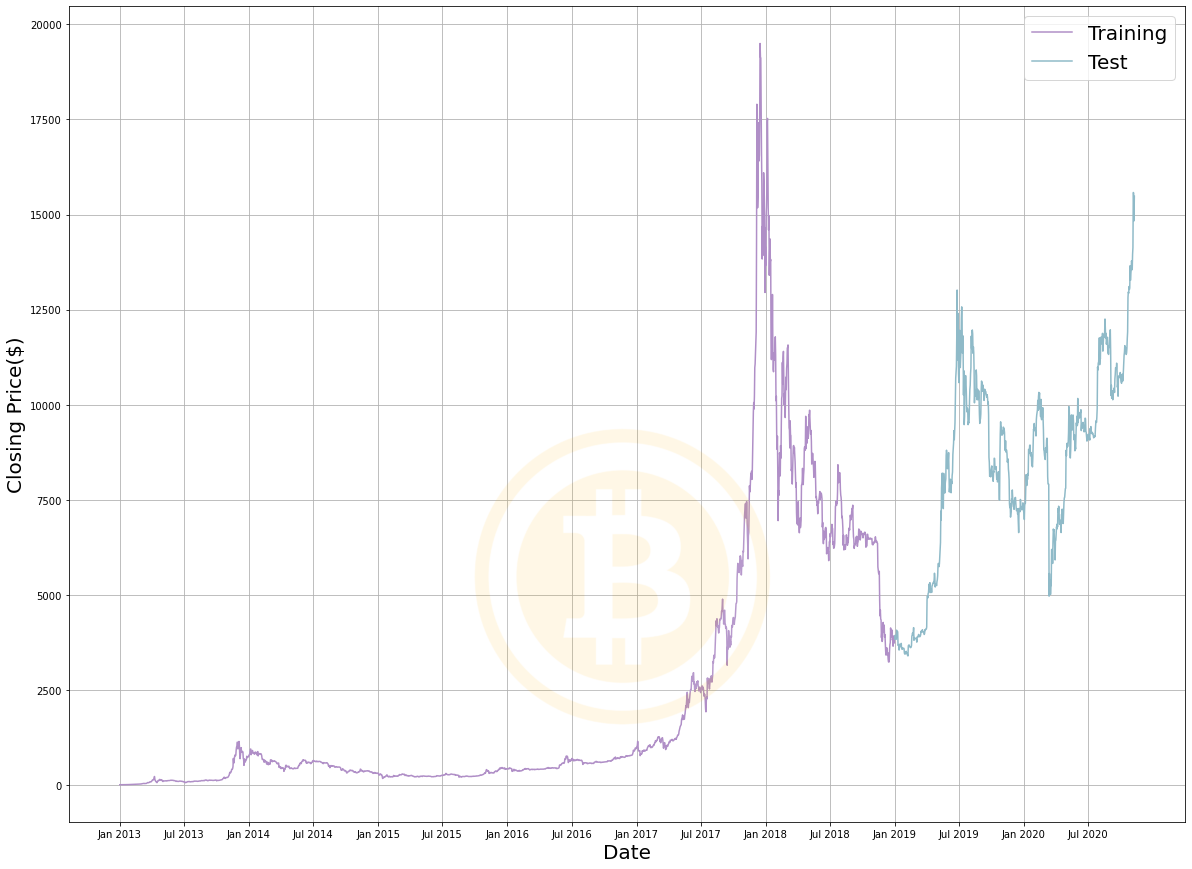

In [10]:
# Split pivot
split_date = '2019-01-01'

# Check the simulated split dataset using plot before split
# Create a canvas
plt.figure(figsize=(20,15))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Closing Price($)", fontsize=20)

# Plot Training dataset chat
plt.plot(price_df[price_df['Date'] < split_date]['Date'],
         price_df[price_df['Date'] < split_date]['Close'],
         color='#B08FC7', label='Training')
# Plot Test dataset chat
plt.plot(price_df[price_df['Date'] >= split_date]['Date'],
         price_df[price_df['Date'] >= split_date]['Close'],
         color='#8FBAC8', label='Test')


# Add grid
plt.grid()

# Set ticks for x axis
plt.xticks(
    [datetime.date(i,j,1) for i in range(2013,2021) for j in [1,7]], 
    [datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,7]],
    fontsize=10
)

# Set Coin logo to figure
plt.figimage(bitcoin_im, 300,50,zorder=2,alpha=.1)

# Plot figure
plt.legend(loc='best', fontsize=20)
# plt.savefig("./price_chat.jpg", dpi=400)   # Save figure as a jpg file if need.
plt.show()

In [11]:
# Split dataset to training set and test set.
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]

# We don't need the date columns anymore 
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [12]:
window_len = 10
norm_cols =['Close']
training_set[training_set['Close']==0] = 1.0e-10

print(training_set.shape)
training_set.head()

(2191, 1)


,Close
364,13.3
363,13.3
362,13.4
361,13.5
360,13.4


## Step 3 - Define LSTM model using keras

In [13]:
# Create LSTM model by keras

LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col] / temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values / training_set['Close'][:-window_len].values) - 1

print(len(LSTM_training_inputs))
LSTM_training_inputs[0]

2181


,Close
364,0.000000
363,0.000000
362,0.007519
361,0.015038
360,0.007519
359,0.007519
358,0.022556
357,0.030075
356,0.037594
355,0.060150


In [14]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col] / temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values) - 1

print(len(LSTM_test_inputs))
LSTM_test_inputs[0]

668


,Close
2555,0.000000
2554,0.025989
2553,-0.001764
2552,0.003695
2551,0.000434
2550,0.060650
2549,0.047282
2548,0.048739
2547,0.049897
2546,-0.042825


In [15]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
# convert [list] to [array]
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)
print("Training inputs size: ", LSTM_training_inputs.shape)
#print(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)
print("Test inputs size: ", LSTM_test_inputs.shape)
#print(LSTM_test_inputs)

Training inputs size:  (2181, 10, 1)
Test inputs size:  (668, 10, 1)


In [16]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(
    inputs, output_size, neurons, 
    activ_func="linear",dropout=0.25, 
    loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [17]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
# train model on data
history = bt_model.fit(
    LSTM_training_inputs, LSTM_training_outputs, 
    epochs=50, batch_size=1, verbose=2, shuffle=True
)

Epoch 1/50
2181/2181 - 7s - loss: 0.0503
Epoch 2/50
2181/2181 - 7s - loss: 0.0394
Epoch 3/50
2181/2181 - 6s - loss: 0.0375
Epoch 4/50
2181/2181 - 6s - loss: 0.0365
Epoch 5/50
2181/2181 - 6s - loss: 0.0373
Epoch 6/50
2181/2181 - 6s - loss: 0.0358
Epoch 7/50
2181/2181 - 6s - loss: 0.0358
Epoch 8/50
2181/2181 - 6s - loss: 0.0365
Epoch 9/50
2181/2181 - 6s - loss: 0.0364
Epoch 10/50
2181/2181 - 7s - loss: 0.0346
Epoch 11/50
2181/2181 - 6s - loss: 0.0354
Epoch 12/50
2181/2181 - 6s - loss: 0.0355
Epoch 13/50
2181/2181 - 6s - loss: 0.0355
Epoch 14/50
2181/2181 - 6s - loss: 0.0349
Epoch 15/50
2181/2181 - 6s - loss: 0.0354
Epoch 16/50
2181/2181 - 6s - loss: 0.0349
Epoch 17/50
2181/2181 - 6s - loss: 0.0346
Epoch 18/50
2181/2181 - 6s - loss: 0.0352
Epoch 19/50
2181/2181 - 6s - loss: 0.0339
Epoch 20/50
2181/2181 - 6s - loss: 0.0340
Epoch 21/50
2181/2181 - 6s - loss: 0.0348
Epoch 22/50
2181/2181 - 6s - loss: 0.0344
Epoch 23/50
2181/2181 - 6s - loss: 0.0353
Epoch 24/50
2181/2181 - 6s - loss: 0.0340
E

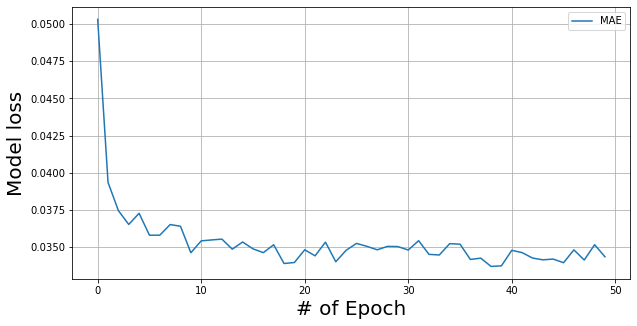

In [18]:
plt.figure(figsize=(10,5))
plt.xlabel("# of Epoch", fontsize=20)
plt.ylabel("Model loss", fontsize=20)

plt.plot(history.history["loss"], label="MAE", ls="-")
#plt.plot(history.history["val_acc"], label="val_acc", ls="-", marker="x")

plt.grid()

plt.legend(loc="best")
plt.show()

## Step 4 - Training result plot

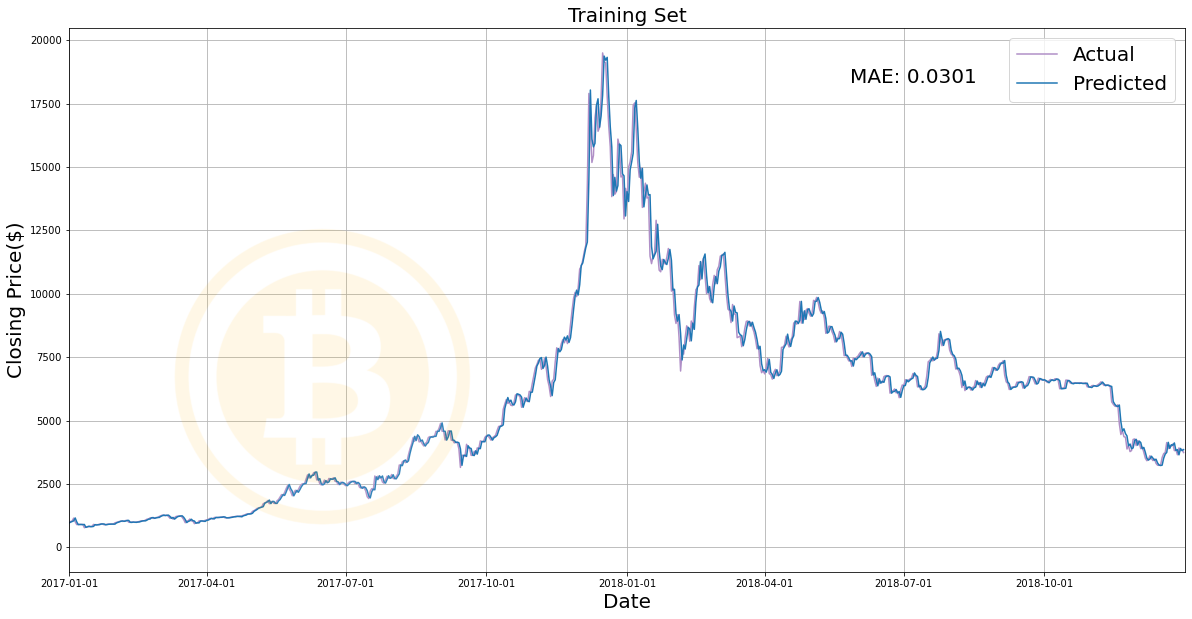

In [19]:
plt.figure(figsize=(20,10))
plt.title('Training Set', fontsize=20)
plt.ylabel('Closing Price($)', fontsize=20)
plt.xlabel("Date", fontsize=20)

plt.plot(
    model_data[model_data['Date'] < split_date]['Date'][window_len:],
    training_set['Close'][window_len:], 
    color='#B08FC7', label='Actual'
)
plt.plot(
    model_data[model_data['Date'] < split_date]['Date'][window_len:],
    ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * 
     training_set["Close"].values[:-window_len])[0],
    label='Predicted'
)
plt.annotate(
    'MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1) -
                               (training_set['Close'].values[window_len:]) / 
                               (training_set['Close'].values[:-window_len]))), 
    xy=(0.7, 0.9),  xycoords='axes fraction',
    xytext=(0.7, 0.9), textcoords='axes fraction', fontsize=20
)

plt.xticks([datetime.date(i,j,1) for i in range(2017,2019) for j in [1,4,7,10]])
plt.xlim([datetime.date(2017,1,1),datetime.date(2019,1,1)])
plt.figimage(bitcoin_im, zorder=3,alpha=.1)
plt.grid()
plt.legend(loc='best', fontsize=20)
plt.savefig("training_result.jpg",dpi=300)

## Step 5 - Test result plot

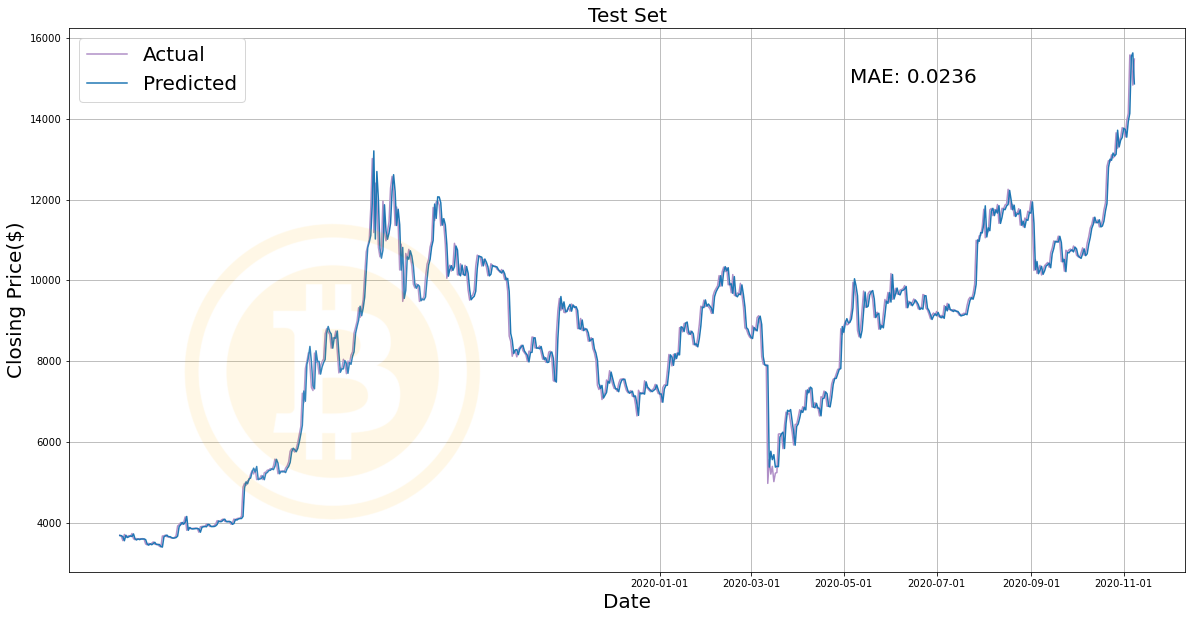

In [20]:
plt.figure(figsize=(20,10))
plt.title('Test Set', fontsize=20)
plt.ylabel('Closing Price($)', fontsize=20)
plt.xlabel("Date", fontsize=20)


plt.plot(
    model_data[model_data['Date'] >= split_date]['Date'][window_len:],
    test_set['Close'][window_len:], color='#B08FC7', label='Actual'
)
plt.plot(
    model_data[model_data['Date'] >= split_date]['Date'][window_len:],
    ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * 
     test_set['Close'].values[:-window_len])[0],label='Predicted'
)

plt.annotate(
    'MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1) - 
                               (test_set['Close'].values[window_len:]) / 
                               (test_set['Close'].values[:-window_len]))), 
    xy=(0.7, 0.9),  xycoords='axes fraction',
    xytext=(0.7, 0.9), textcoords='axes fraction', fontsize=20
)

plt.xticks([datetime.date(i,j,1) for i in range(2020,2021) for j in [1,3,5,7,9,11]])

plt.grid()
plt.figimage(bitcoin_im, xo=10, yo=5, alpha=.1)
plt.legend(loc='best', fontsize=20)
plt.savefig("Test_result.jpg",dpi=300)